In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("./Data/Titanic_train.csv")
test_df = pd.read_csv("./Data/Titanic_test.csv")

In [3]:
age_median = train_df['Age'].median()
train_df['Age'] = train_df['Age'].fillna(age_median)
test_df['Age'] = test_df['Age'].fillna(age_median)

embarked_mode = train_df['Embarked'].mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(embarked_mode)
test_df['Embarked'] = test_df['Embarked'].fillna(embarked_mode)

train_df.drop(columns=['Cabin', 'PassengerId'], inplace=True)
test_df.drop(columns=['Cabin', 'PassengerId'], inplace=True)

# Impute missing Fare in test set using median Fare by Pclass
missing_fare_index = test_df[test_df['Fare'].isnull()].index[0]
pclass = test_df.loc[missing_fare_index, 'Pclass']
fare_median = test_df[test_df['Pclass'] == pclass]['Fare'].median()

test_df.loc[missing_fare_index, 'Fare'] = fare_median

def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train_df['title'] = train_df['Name'].apply(extract_title)
test_df['title'] = test_df['Name'].apply(extract_title)

print("Train Titles:\n", train_df['title'].value_counts())
print("\nTest Titles:\n", test_df['title'].value_counts())

# Mapping dictionary
title_mapping = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Dr": "Professional",
    "Rev": "Professional",
    "Sir": "Royalty",
    "Lady": "Royalty",
    "Don": "Royalty",
    "Jonkheer": "Royalty",
    "the Countess": "Royalty",
    "Dona": "Royalty"
}

# Apply mapping
train_df['title'] = train_df['title'].replace(title_mapping)
test_df['title'] = test_df['title'].replace(title_mapping)

# Check the new title counts
print("Cleaned Train Titles:\n", train_df['title'].value_counts())
print("\nCleaned Test Titles:\n", test_df['title'].value_counts())

zero_fare_passengers = train_df[train_df['Fare'] == 0][['Name', 'Fare', 'Ticket', 'Age', 'Pclass', 'title']]
zero_fare_passengers

# isVIP: Passenger is considered VIP if title is 'Royalty' or Fare is 0
train_df['isVIP'] = (
    (train_df['title'] == 'Royalty') | 
    (train_df['Fare'] == 0)
).astype(int)

test_df['isVIP'] = (
    (test_df['title'] == 'Royalty') | 
    (test_df['Fare'] == 0)
).astype(int)

print("Cleaned Train Titles:\n", train_df['isVIP'].value_counts())
print("\nCleaned Test Titles:\n", test_df['isVIP'].value_counts())

def get_age_category(age):
    if age < 3:
        return 'Infant'
    elif age < 13:
        return 'Child'
    elif age < 18:
        return 'Teen'
    elif age < 60:
        return 'Adult'
    else:
        return 'Senior'

train_df['age_category'] = train_df['Age'].apply(get_age_category)
test_df['age_category'] = test_df['Age'].apply(get_age_category)

print("Cleaned Train Titles:\n", train_df['age_category'].value_counts())
print("\nCleaned Test Titles:\n", test_df['age_category'].value_counts())

train_df.drop(columns=['Age'], inplace=True)
test_df.drop(columns=['Age'], inplace=True)

train_df['surname'] = train_df['Name'].apply(lambda x: x.split(',')[0].strip())
test_df['surname'] = test_df['Name'].apply(lambda x: x.split(',')[0].strip())

surname_counts_train = train_df['surname'].value_counts()
print(f"urname_counts_train:\n{surname_counts_train}", end="\n\n")
train_df['surname_count'] = train_df['surname'].map(surname_counts_train)

surname_counts_test = test_df['surname'].value_counts()
print(f"surname_counts_test:\n{surname_counts_test}", end="\n\n")
test_df['surname_count'] = test_df['surname'].map(surname_counts_test)

immediate_family_train = train_df['Parch'] + train_df['SibSp'] + 1
train_df['family_size'] = np.where(
    train_df['surname_count'] > immediate_family_train,
    immediate_family_train + (train_df['surname_count'] - immediate_family_train),
    immediate_family_train
)

immediate_family_test = test_df['Parch'] + test_df['SibSp'] + 1
test_df['family_size'] = np.where(
    test_df['surname_count'] > immediate_family_test,
    immediate_family_test + (test_df['surname_count'] - immediate_family_test),
    immediate_family_test
)

train_df.drop(columns=['Name', 'Parch', 'SibSp', 'surname', 'surname_count'], inplace=True)
test_df.drop(columns=['Name', 'Parch', 'SibSp', 'surname', 'surname_count'], inplace=True)

train_df.drop(columns=['Ticket', 'Embarked'], inplace=True)
test_df.drop(columns=['Ticket', 'Embarked'], inplace=True)

categorical_features = ['Sex', 'title', 'age_category']
numerical_features = ['Pclass', 'Fare', 'isVIP', 'family_size']

X = train_df[categorical_features + numerical_features]
y = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_val_cat = encoder.transform(X_val[categorical_features])

# Get encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Convert to DataFrames
X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_feature_names, index=X_train.index)
X_val_cat_df = pd.DataFrame(X_val_cat, columns=encoded_feature_names, index=X_val.index)

# Concatenate encoded categorical and numerical features
X_train_encoded = pd.concat([X_train_cat_df, X_train[numerical_features]], axis=1)
X_val_encoded = pd.concat([X_val_cat_df, X_val[numerical_features]], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

Train Titles:
 title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

Test Titles:
 title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64
Cleaned Train Titles:
 title
Mr              517
Miss            185
Mrs             126
Master           40
Professional     13
Royalty           5
Officer           5
Name: count, dtype: int64

Cleaned Test Titles:
 title
Mr              240
Miss             79
Mrs              72
Master           21
Professional      3
Officer           2
Royalty           1
Name: count, dtype: int64
Cleaned Train Titles:
 isVIP
0    872
1     19
Nam

In [4]:
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),

    Dense(1, activation='sigmoid')
])

/Users/rohandas/Documents/GitHub/ML_Project/tfenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    verbose=1
)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5527 - loss: 0.7820 - val_accuracy: 0.7639 - val_loss: 0.6307
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7837 - loss: 0.6290 - val_accuracy: 0.7778 - val_loss: 0.5450
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8190 - loss: 0.5501 - val_accuracy: 0.7639 - val_loss: 0.5416
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.7634 - loss: 0.5667 - val_accuracy: 0.7639 - val_loss: 0.5301
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7818 - loss: 0.5452 - val_accuracy: 0.7917 - val_loss: 0.5301
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7970 - loss: 0.4940 - val_accuracy: 0.8056 - val_loss: 0.5240
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7947 - loss: 0.5326 - val_accuracy: 0.7917 - val_loss: 0.5322
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.7973 - loss: 0.5201 - val_accuracy: 0.8

In [7]:
loss, acc = model.evaluate(X_val_scaled, y_val)
print(f"Validation Accuracy: {acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8092 - loss: 0.5736
Validation Accuracy: 0.8101


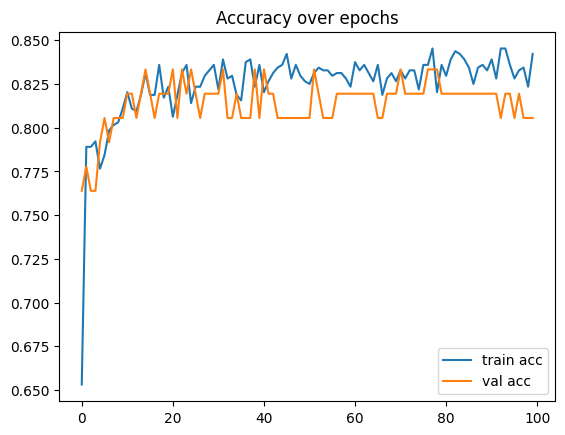

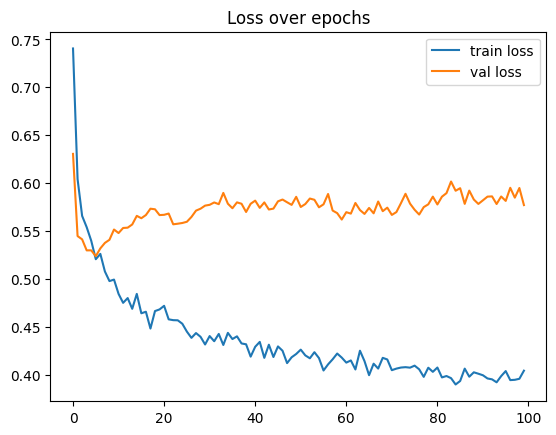

In [8]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


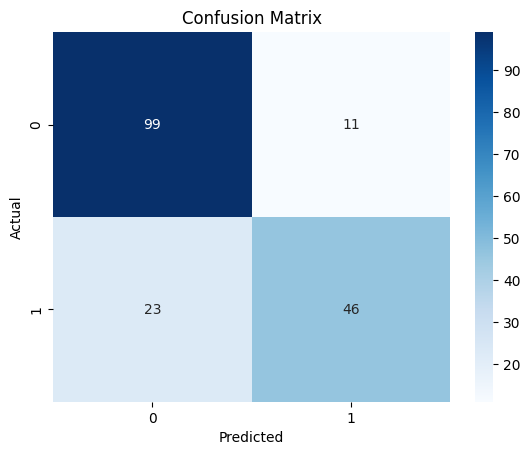

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



In [9]:
# Predict
y_pred_probs = model.predict(X_val_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Metrics
print(classification_report(y_val, y_pred))